# Test on FLCHAIN

In [1]:
import numpy

In [2]:
import sklearn

In [3]:
import survhive

In [4]:
survhive.list_available_datasets()

('flchain', 'gbsg2', 'metabric', 'support')

In [5]:
mb_df = survhive.get_data('flchain')
mb_df.dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6524 entries, 0 to 6523
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   age         6524 non-null   float64
 1   sex         6524 non-null   float64
 2   sample.yr   6524 non-null   int64  
 3   kappa       6524 non-null   float64
 4   lambda      6524 non-null   float64
 5   flc.grp     6524 non-null   int64  
 6   creatinine  6524 non-null   float64
 7   mgus        6524 non-null   float64
 8   time        6524 non-null   float64
 9   event       6524 non-null   float64
dtypes: float64(8), int64(2)
memory usage: 560.7 KB


In [6]:
X, y = mb_df.get_X_y()
X.shape, y.shape

((6524, 8), (6524,))

In [7]:
y[:10]

array([( True,   85.), ( True, 1281.), ( True,   69.), ( True,  115.),
       ( True, 1039.), ( True, 1355.), ( True, 2851.), ( True,  372.),
       ( True, 3309.), ( True, 1326.)],
      dtype=[('event', '?'), ('time', '<f8')])

### Generate a (stratified) train-test split and Scale the features (only) 

First do the stratified splitting THEN do scaling, parameterized on X_train set ONLY 

In [8]:
from sklearn.preprocessing import StandardScaler, RobustScaler

In [9]:
X_train, X_test, y_train, y_test = survhive.survival_train_test_split(X, y, rng_seed=2309)

In [10]:
scaler = StandardScaler().fit(X_train)
[X_train, X_test] = [ scaler.transform(_) for _ in  [X_train, X_test] ]
X_train.shape, X_test.shape

((4893, 8), (1631, 8))

In [11]:
survhive.get_indicator(y).sum(), survhive.get_indicator(y_train).sum(), survhive.get_indicator(y_test).sum(),


(1962, 1472, 490)

## check possible dimensionality reduction

In [12]:
from sklearn.decomposition import PCA

In [13]:
pca= PCA(n_components=0.995, random_state=2308).fit(X_train)
print('PCA components:',pca.n_components_)

PCA components: 8


Massive (50%) reduction using PCA

In [14]:
## Stratified CV spliter for survival analysis

In [15]:
#from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold

In [16]:
#testkf= RepeatedStratifiedKFold(n_splits=5,n_repeats=2,random_state=2307)
#for trn,tst in testkf.split(X_train, survhive.get_indicator(y_train)):
#    print(trn,tst) 

# test coxnet

In [17]:
coxnet = survhive.CoxNet(rng_seed=2309)
coxnet.fit(X_train, y_train)

CoxNet(rng_seed=2309, l1_ratio=0.5, verbose=False, fit_baseline_model=False)

In [18]:
coxnet.score(X_test, y_test)

0.7927079761717836

In [19]:
#from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [21]:
coxnet.get_parameter_grid()

{'l1_ratio': [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]}

In [22]:
opt_coxnet, opt_coxnet_params, opt_coxnet_search = survhive.optimize(coxnet, X_train, y_train,  n_jobs=4)
opt_coxnet.score(X_test, y_test), opt_coxnet_params

(0.7929050492362217, {'l1_ratio': 0.01})

In [24]:
survhive.get_top_models(opt_coxnet_search, X_test, y_test)

[(1, 0.7908660030457184, 0.013578576459717839, {'l1_ratio': 0.01}),
 (2, 0.790853929619151, 0.013575786215731024, {'l1_ratio': 0.1}),
 (3, 0.7908424033057694, 0.013587621352660808, {'l1_ratio': 0.25}),
 (4, 0.7908046510956237, 0.01358534558473881, {'l1_ratio': 0.5}),
 (5, 0.7907654260533723, 0.013603444287500337, {'l1_ratio': 0.75}),
 (6, 0.7907518540000099, 0.013597551300141642, {'l1_ratio': 0.9}),
 (7, 0.7907474755844599, 0.01361259181444461, {'l1_ratio': 0.99})]

# Test DSM

In [81]:
batch5 = int(X_train.shape[0] /20 ) 

In [114]:
fl_dsm=survhive.DeepSurvivalMachines(rng_seed=2309, batch_size=batch5, layer_sizes=[4], validation_size=0.2, learning_rate=0.1, max_epochs=1000)
fl_dsm

DeepSurvivalMachines(rng_seed=2309, n_distr=2, distr_kind='Weibull', batch_size=244, layer_sizes=[4], learning_rate=0.1, validation_size=0.2, max_epochs=1000, elbo=False)

In [115]:
#fl_dsm.layer_sizes=[3]
#fl_dsm.learning_rate=0.01
fl_dsm_xplore=fl_dsm.fit(X_train,y_train)
fl_dsm_xplore.score(X_train,y_train)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.18it/s]


ValueError: Input estimate contains NaN.

In [27]:
grid =survhive.DeepSurvivalMachines.get_parameter_grid(max_width=X_train.shape[1])
grid

{'n_distr': [1, 2, 3],
 'distr_kind': ['Weibull'],
 'batch_size': [16, 32],
 'layer_sizes': [[3],
  [4],
  [5],
  [7],
  [3, 3],
  [4, 4],
  [5, 5],
  [7, 7],
  [3, 3, 3],
  [4, 4, 4],
  [5, 5, 5],
  [7, 7, 7]],
 'learning_rate': [0.005, 0.001],
 'validation_size': [0.1],
 'max_epochs': [100],
 'elbo': [False]}

In [29]:
# Stratified CV
#opt_dsm, opt_dsm_params, opt_dsm_search = optimize(survhive.DeepSurvivalMachines(rng_seed=2308),  X_train, y_train, n_jobs=8,
                                                  # user_grid=grid,cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=2308).split(X_train,survhive.get_indicator(y_train)))
#opt_dsm.score(X_test, y_test), opt_dsm_params

In [109]:
# Stratified CV
fl_dsm=survhive.DeepSurvivalMachines(rng_seed=2309,max_epochs=200, validation_size=0.2, batch_size=batch5)
fl_grid=fl_dsm.get_parameter_grid(max_width=3)
fl_grid['batch_size']=[batch5]
fl_grid['n_distr']=[2]
fl_grid

{'n_distr': [2],
 'distr_kind': ['Weibull'],
 'batch_size': [244],
 'layer_sizes': [[3], [3, 3], [3, 3, 3]],
 'learning_rate': [0.005, 0.001],
 'validation_size': [0.1],
 'max_epochs': [100],
 'elbo': [False]}

In [110]:
opt_dsm, opt_dsm_params, opt_dsm_search = survhive.optimize(fl_dsm,  X_train, y_train, user_grid=fl_grid, n_jobs=2)
opt_dsm.score(X_test, y_test), opt_dsm_params

 89%|████████▉ | 89/100 [00:02<00:00, 34.26it/s]/usr/local/ivan/Unito/conda/envs/tosa/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/ivan/Unito/conda/envs/tosa/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/ivan/Unito/conda/envs/tosa/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/ivan/Unito/survhive/survhive/auton_adapters.py", line 95, in score
    return self.harrell_score(y, self.predict(X))[0]
  File "/usr/local/ivan/Unito/survhive/survhive/auton_adapters.py", line 83, in harrell_score
    return concordance_index_censored(
  File "/usr/local/ivan/Unito/conda/envs/tosa/lib/p

KeyboardInterrupt: 

In [42]:
cv_res = opt_dsm_search.cv_results_
rez=sorted(zip(cv_res['rank_test_score'], cv_res['mean_test_score'] , cv_res['std_test_score'], 
               cv_res['mean_test_score'] - cv_res['std_test_score'], opt_dsm_search.cv_results_['params']))
rez[:10]

[(1,
  0.6439123236055904,
  0.013331054406781466,
  0.6305812691988089,
  {'batch_size': 32,
   'distr_kind': 'Weibull',
   'elbo': False,
   'layer_sizes': [7],
   'learning_rate': 0.001,
   'max_epochs': 100,
   'n_distr': 2,
   'validation_size': 0.1}),
 (2,
  0.641216329625738,
  0.013656838752293343,
  0.6275594908734448,
  {'batch_size': 32,
   'distr_kind': 'Weibull',
   'elbo': False,
   'layer_sizes': [8, 8, 8],
   'learning_rate': 0.001,
   'max_epochs': 100,
   'n_distr': 2,
   'validation_size': 0.1}),
 (3,
  0.6410448389376093,
  0.01578927172475547,
  0.6252555672128539,
  {'batch_size': 32,
   'distr_kind': 'Weibull',
   'elbo': False,
   'layer_sizes': [6, 6],
   'learning_rate': 0.001,
   'max_epochs': 100,
   'n_distr': 2,
   'validation_size': 0.1}),
 (4,
  0.6401690073828874,
  0.0085377368984144,
  0.631631270484473,
  {'batch_size': 32,
   'distr_kind': 'Weibull',
   'elbo': False,
   'layer_sizes': [6],
   'learning_rate': 0.001,
   'max_epochs': 100,
   'n_dist

In [43]:
low_bound = sorted(rez[:10], key= lambda k: k[3], reverse=True)
for lb in [ _ for _ in low_bound if _[3] > 0.5] :
    print(lb[0:4])
    test_model(survhive.DeepSurvivalMachines, **lb[4])

(4, 0.6401690073828874, 0.0085377368984144, 0.631631270484473)


 13%|███████▍                                                 | 13/100 [00:01<00:12,  7.19it/s]


Train:  0.6486 , Test: 0.6522
(1, 0.6439123236055904, 0.013331054406781466, 0.6305812691988089)


 23%|█████████████                                            | 23/100 [00:02<00:09,  7.86it/s]


Train:  0.6579 , Test: 0.6666
(2, 0.641216329625738, 0.013656838752293343, 0.6275594908734448)


 26%|██████████████▊                                          | 26/100 [00:03<00:10,  7.01it/s]


Train:  0.6614 , Test: 0.6682
(5, 0.6392439596135209, 0.013189568452178372, 0.6260543911613425)


 33%|██████████████████▊                                      | 33/100 [00:04<00:08,  7.73it/s]


Train:  0.6625 , Test: 0.6661
(7, 0.6373802236649386, 0.011519852514337724, 0.6258603711506009)


 13%|███████▍                                                 | 13/100 [00:01<00:10,  8.47it/s]


Train:  0.6424 , Test: 0.6341
(10, 0.6355773888965156, 0.010116405584353453, 0.6254609833121622)


 15%|████████▌                                                | 15/100 [00:01<00:11,  7.71it/s]


Train:  0.6481 , Test: 0.6642
(3, 0.6410448389376093, 0.01578927172475547, 0.6252555672128539)


 13%|███████▍                                                 | 13/100 [00:01<00:12,  6.90it/s]


Train:  0.6500 , Test: 0.6492
(6, 0.6374513258647787, 0.012825806218798695, 0.62462551964598)


 14%|███████▉                                                 | 14/100 [00:02<00:13,  6.42it/s]


Train:  0.6542 , Test: 0.6551
(9, 0.6356634920689161, 0.011565403723919947, 0.6240980883449962)


 13%|███████▍                                                 | 13/100 [00:02<00:13,  6.44it/s]


Train:  0.6482 , Test: 0.6479
(8, 0.6358725130321964, 0.01804665694618733, 0.617825856086009)


 33%|██████████████████▊                                      | 33/100 [00:03<00:07,  9.08it/s]

Train:  0.6583 , Test: 0.6545


In [53]:
test_model(survhive.DeepSurvivalMachines, batch_size=32, layer_sizes=[7], n_distr=2, max_epochs=200)

 12%|██████████████▊                                                                                                                  | 23/200 [00:01<00:14, 11.87it/s]

Train:  0.6579 , Test: 0.6666


0.6665853628028569

# PyCox

In [55]:
#import pycox.models

In [59]:
fl_dhs = survhive.DeepHitSingle(rng_seed=2309)
fl_dhs

DeepHitSingle(rng_seed=2309, num_durations=10, layer_sizes=[10, 10], epochs=10, batch_size=16, validation_size=0.1, learning_rate=0.001, dropout=0.1, device='cpu')

In [58]:
dhs_grid = dhs.get_parameter_grid(max_width=8)
dhs_grid

{'num_durations': [10],
 'layer_sizes': [[3],
  [4],
  [5],
  [7],
  [3, 3],
  [4, 4],
  [5, 5],
  [7, 7],
  [3, 3, 3],
  [4, 4, 4],
  [5, 5, 5],
  [7, 7, 7]],
 'epochs': [100],
 'batch_size': [16, 32],
 'dropout': [0.1, 0.2, 0.3],
 'validation_size': [0.1]}

In [72]:
fl_dhs.layer_sizes=[10,10,10]
fl_dhs.learning_rate=0.01
fl_dhs.batch_size=32
fl_dhs_xplore=fl_dhs.fit(X_train,y_train)
fl_dhs_xplore.score(X_train,y_train)

0.7931254345893516

<Axes: >

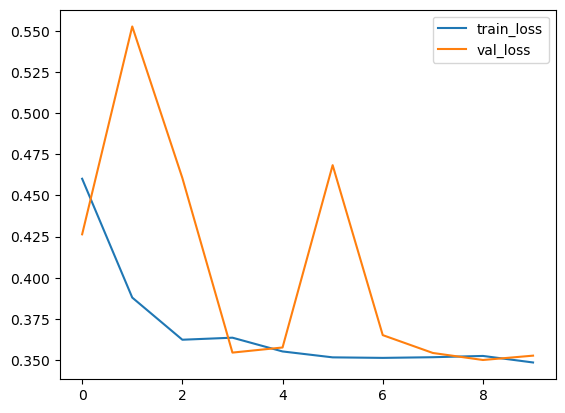

In [73]:
fl_dhs_xplore.training_log_.plot()

In [74]:
dhs_grid['batch_size']=[32]
dhs_grid['dropout']=[0.2]
dhs_grid

{'num_durations': [10],
 'layer_sizes': [[3],
  [4],
  [5],
  [7],
  [3, 3],
  [4, 4],
  [5, 5],
  [7, 7],
  [3, 3, 3],
  [4, 4, 4],
  [5, 5, 5],
  [7, 7, 7]],
 'epochs': [100],
 'batch_size': [32],
 'dropout': [0.2],
 'validation_size': [0.1]}

In [ ]:
opt__dhs, opt_dhs_params, opt_dhs_search = survhive.optimize(fl_dhs, X_train, y_train,user_grid=dhs_grid)

In [79]:
opt__dhs.score(X_test, y_test), opt_dhs_params

(0.7949943441632726,
 {'batch_size': 32,
  'dropout': 0.2,
  'epochs': 100,
  'layer_sizes': [5, 5],
  'num_durations': 10,
  'validation_size': 0.1})

<Axes: >

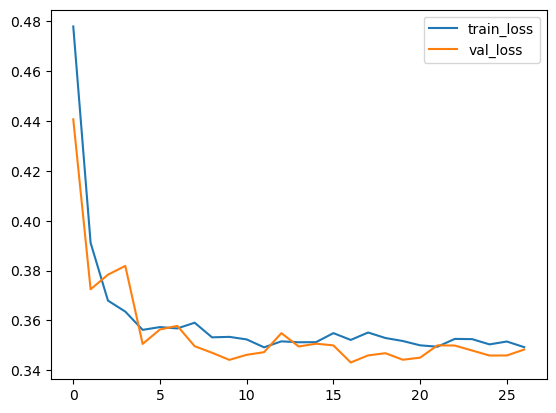

In [80]:
opt__dhs.training_log_.plot()

In [78]:
survhive.get_top_models(opt_dhs_search, X_test, y_test)

[(1,
  0.7927399916143336,
  0.013422081671170243,
  {'batch_size': 32,
   'dropout': 0.2,
   'epochs': 100,
   'layer_sizes': [5, 5],
   'num_durations': 10,
   'validation_size': 0.1}),
 (2,
  0.7921540863768431,
  0.01347731694802788,
  {'batch_size': 32,
   'dropout': 0.2,
   'epochs': 100,
   'layer_sizes': [5, 5, 5],
   'num_durations': 10,
   'validation_size': 0.1}),
 (3,
  0.7916013747347811,
  0.013502402920411556,
  {'batch_size': 32,
   'dropout': 0.2,
   'epochs': 100,
   'layer_sizes': [5],
   'num_durations': 10,
   'validation_size': 0.1}),
 (4,
  0.7914767806975285,
  0.013004894822233085,
  {'batch_size': 32,
   'dropout': 0.2,
   'epochs': 100,
   'layer_sizes': [3, 3],
   'num_durations': 10,
   'validation_size': 0.1}),
 (5,
  0.7913469253931625,
  0.012888061854199074,
  {'batch_size': 32,
   'dropout': 0.2,
   'epochs': 100,
   'layer_sizes': [7, 7],
   'num_durations': 10,
   'validation_size': 0.1}),
 (6,
  0.7912872264589248,
  0.014945716541755232,
  {'batch_

## Note su flchain

1. Miglioramento nullo  rispetto a Coxnet dei metodi deep.
2. Le migliori soluzioni si ottengono con già con un singolo strato nascosto.
4. Pycox converge bene auton non converge mai